# Imports

In [159]:
import os
from datetime import datetime, timedelta
import pandas as pd
from xgboost import XGBRegressor
import json
import time

import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import plot_importance
from matplotlib.patches import Patch

import hopsworks

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Feature Stores Retrieval from Hopsworks

## Login & Retrieve All Feature Stores

In [183]:
project = hopsworks.login(engine="python", project='terahidro2003')
fs = project.get_feature_store()

2025-11-10 17:23:55,856 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-10 17:23:55,859 INFO: Initializing external client
2025-11-10 17:23:55,859 INFO: Base URL: https://c.app.hopsworks.ai:443
Connection closed.
2025-11-10 17:23:55,859 INFO: Initializing external client
2025-11-10 17:23:55,859 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-10 17:23:55,856 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-10 17:23:55,859 INFO: Initializing external client
2025-11-10 17:23:55,859 INFO: Base URL: https://c.app.hopsworks.ai:443
Connection closed.
2025-11-10 17:23:55,859 INFO: Initializing external client
2025-11-10 17:23:55,859 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-10 17:23:55,856 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-10 17:23:55,859 INFO: Initializing external client
2025-11-10 17:23:55,859 INFO: Base URL: https://c.app.hopsworks.ai:443
Connection closed.
2025-11-10 17:23:55,859 INFO: Initializing external client
2025-11-10 17:23:55,859 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-10 17:23:57,113 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286307

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286307


## Retrieve Air Quality and Wind Feature Stores

In [188]:
pm25_daily_fg = fs.get_feature_group(
    name="pm25_daily",
    version=1
)

wind_direction_hourly_fg = fs.get_feature_group(
    name="wind_direction_hourly",
    version=1
)

wind_speed_hourly_fg = fs.get_feature_group(
    name="wind_speed_hourly",
    version=1
)

air_temperature_hourly_fg = fs.get_feature_group(
    name="air_temperature_hourly",
    version=1
)

# Show what you actually got back for each FG call
print("pm25_daily_fg:", "Loaded" if pm25_daily_fg is not None else "Not Loaded")
print("wind_direction_hourly_fg:", "Loaded" if wind_direction_hourly_fg is not None else "Not Loaded")
print("wind_speed_hourly_fg:", "Loaded" if wind_speed_hourly_fg is not None else "Not Loaded")
print("air_temperature_hourly_fg:", "Loaded" if air_temperature_hourly_fg is not None else "Not Loaded")

pm25_daily_fg: Loaded
wind_direction_hourly_fg: Loaded
wind_speed_hourly_fg: Loaded
air_temperature_hourly_fg: Loaded


# Feature View Creation

Join different feature groups (i.e., pm25, air speed and direction) together.

In [191]:
REGION = "west"

selected_features = pm25_daily_fg.select(["pm25", "timestamp"]).join(
    wind_direction_hourly_fg.select_features(), on=["region"]
).join(
    wind_speed_hourly_fg.select_features(), on=["region"]
).join(
    air_temperature_hourly_fg.select_features(), on=["region"]
)

2025-11-10 17:29:59,509 INFO: Using ['station_name', 'wind_direction_avg', 'wind_direction_std', 'reading_count', 'latitude', 'longitude', 'hour', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'wind_u', 'wind_v', 'wind_u_lag_1h', 'wind_v_lag_1h', 'wind_direction_lag_1h', 'wind_u_lag_2h', 'wind_v_lag_2h', 'wind_direction_lag_2h', 'wind_u_lag_3h', 'wind_v_lag_3h', 'wind_direction_lag_3h', 'wind_u_lag_6h', 'wind_v_lag_6h', 'wind_direction_lag_6h', 'wind_u_lag_12h', 'wind_v_lag_12h', 'wind_direction_lag_12h', 'wind_u_lag_24h', 'wind_v_lag_24h', 'wind_direction_lag_24h', 'wind_u_lag_48h', 'wind_v_lag_48h', 'wind_direction_lag_48h', 'wind_u_lag_72h', 'wind_v_lag_72h', 'wind_direction_lag_72h', 'wind_u_lag_168h', 'wind_v_lag_168h', 'wind_direction_lag_168h', 'wind_u_rolling_mean_6h', 'wind_v_rolling_mean_6h', 'direction_std_rolling_mean_6h', 'wind_u_rolling_mean_12h', 'wind_v_rolling_mean_12h', 'direction_std_rolling_mean_12h', 'wind_u_rolling_mean_24h', 'wind_v_rolling_mean_2

Create a feature view - selection of features from different feature groups that define I/O API of a model.

In [192]:
feature_view = fs.get_or_create_feature_view(
    name="air_quality_wind_temperature_features",
    version=1,
    description="Feature view with air quality and weather features (wind speed/direction and temperature)",
    labels=['pm25'],
    query=selected_features
)

2025-11-10 17:30:01,343 WARNING: Ambiguous features detected during query construction.The feature `year` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `is_weekend` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `latitude` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `reading_count` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `hour` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `month` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_h

# Splitting the Data into Train/Test Data Sets

In [193]:
start_date = "2025-10-20"

test_start = datetime.strptime(start_date, "%Y-%m-%d")
print("Test data starts from:", test_start.date())

Test data starts from: 2025-10-01


## Split data based on Start Date

In [195]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (17.37s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (17.37s) 
2025-11-10 17:31:08,706 WARNING: VersionWarning: Incremented version to `2`.

2025-11-10 17:31:08,706 WARNING: VersionWarning: Incremented version to `2`.



### Output Samples from each set

In [201]:
X_train.head(25000)

,timestamp,station_name,wind_direction_avg,wind_direction_std,reading_count,latitude,longitude,hour,day_of_week,day_of_month,...,air_temperature_hourly_air_temperature_rolling_min_24h,air_temperature_hourly_air_temperature_rolling_max_24h,air_temperature_hourly_air_temperature_rolling_mean_72h,air_temperature_hourly_air_temperature_rolling_std_72h,air_temperature_hourly_air_temperature_rolling_min_72h,air_temperature_hourly_air_temperature_rolling_max_72h,air_temperature_hourly_air_temperature_rolling_mean_168h,air_temperature_hourly_air_temperature_rolling_std_168h,air_temperature_hourly_air_temperature_rolling_min_168h,air_temperature_hourly_air_temperature_rolling_max_168h
0,2023-01-23 00:00:00+00:00,Clementi Road,289.163160,0.299022,59.0,1.3337,103.7768,8.0,0.0,23.0,...,24.115000,28.751667,26.016571,1.684419,24.115000,31.150000,26.591922,1.915485,24.115000,31.735000
1,2023-02-23 00:00:00+00:00,Clementi Road,2.198954,0.250819,58.0,1.3337,103.7768,8.0,3.0,23.0,...,25.006667,29.718333,26.644716,1.684363,24.243333,30.198333,26.844346,1.879765,24.111667,31.573333
2,2023-04-11 00:00:00+00:00,Clementi Road,9.473178,0.802047,59.0,1.3337,103.7768,8.0,1.0,11.0,...,24.175000,32.195000,27.304550,2.317624,24.175000,33.011667,27.697218,2.142257,23.908475,33.118333
3,2023-04-17 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.000000,32.481667,28.609509,2.025321,25.000000,32.828333,28.600133,2.335784,24.175000,33.798333
4,2023-04-22 00:00:00+00:00,Clementi Road,95.210535,0.177237,59.0,1.3337,103.7768,8.0,5.0,22.0,...,24.655932,31.240000,27.900082,1.867348,23.260000,31.240000,28.395708,2.026895,23.260000,34.165000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20769,2022-10-23 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20770,2022-11-05 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20771,2022-11-09 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20772,2022-12-25 00:00:00+00:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
y_train

,pm25
0,25.0
1,32.0
2,57.0
3,56.0
4,29.0
...,...
20769,19.0
20770,30.0
20771,34.0
20772,33.0


In [388]:
X_features = X_train.drop(columns=['timestamp'])
X_test_features = X_test.drop(columns=['timestamp'])
X_features.dropna(inplace=True)
mask = X_features.dropna().index
X_features = X_features.loc[mask].reset_index(drop=True)
y_train = y_train.loc[mask].reset_index(drop=True)
X_features

,station_name,wind_direction_avg,wind_direction_std,reading_count,latitude,longitude,hour,day_of_week,day_of_month,month,...,air_temperature_hourly_air_temperature_rolling_min_24h,air_temperature_hourly_air_temperature_rolling_max_24h,air_temperature_hourly_air_temperature_rolling_mean_72h,air_temperature_hourly_air_temperature_rolling_std_72h,air_temperature_hourly_air_temperature_rolling_min_72h,air_temperature_hourly_air_temperature_rolling_max_72h,air_temperature_hourly_air_temperature_rolling_mean_168h,air_temperature_hourly_air_temperature_rolling_std_168h,air_temperature_hourly_air_temperature_rolling_min_168h,air_temperature_hourly_air_temperature_rolling_max_168h
0,Clementi Road,330.570033,0.189213,59.0,1.3337,103.7768,8.0,4.0,20.0,1.0,...,24.325000,28.626667,26.944004,2.053828,24.325000,31.735000,27.002773,2.059948,24.325000,31.735000
1,Clementi Road,2.482398,1.165144,59.0,1.3337,103.7768,8.0,5.0,21.0,1.0,...,24.486667,28.170000,26.211869,1.584878,24.325000,30.553333,26.938685,2.018901,24.325000,31.735000
2,Clementi Road,342.123353,0.645884,57.0,1.3337,103.7768,8.0,6.0,22.0,1.0,...,24.488333,31.150000,26.193414,1.628352,24.325000,31.150000,26.962110,2.002968,24.325000,31.735000
3,Clementi Road,289.163160,0.299022,59.0,1.3337,103.7768,8.0,0.0,23.0,1.0,...,24.115000,28.751667,26.016571,1.684419,24.115000,31.150000,26.591922,1.915485,24.115000,31.735000
4,Clementi Road,320.633463,0.120366,59.0,1.3337,103.7768,8.0,1.0,24.0,1.0,...,23.895000,26.928333,25.730313,1.785027,23.895000,31.150000,26.231243,1.911517,23.895000,31.735000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,Sentosa,55.598066,0.122812,60.0,1.2500,103.8279,8.0,2.0,15.0,10.0,...,27.983333,32.028333,28.525278,1.090716,26.036667,32.028333,28.590813,1.262762,24.225000,32.028333
4961,Sentosa,351.109220,0.167786,59.0,1.2500,103.8279,8.0,3.0,16.0,10.0,...,27.125000,31.421667,28.938287,1.140378,27.125000,32.028333,28.628135,1.301738,24.225000,32.028333
4962,Sentosa,270.195265,0.998167,60.0,1.2500,103.8279,8.0,4.0,17.0,10.0,...,27.631667,31.250000,29.209838,1.217130,27.125000,32.028333,28.916548,1.238990,26.036667,32.028333
4963,Sentosa,283.577554,0.271873,60.0,1.2500,103.8279,8.0,5.0,18.0,10.0,...,25.583333,31.013333,29.168495,1.378571,25.583333,31.421667,28.870655,1.257881,25.583333,32.028333


# Modeling

In [389]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.02, max_depth=20, objective='reg:squarederror', tree_method='hist', sampling_method='uniform', n_jobs=8, random_state=42)

X_features = X_features.select_dtypes(include=["number"]).copy()
X_test_features = X_test_features.select_dtypes(include=["number"]).copy()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=8,
             num_parallel_tree=None, random_state=42, ...)

In [390]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2025-11-10 19:02:21,491 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 19:02:21,491 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 154.37284011722218
2025-11-10 19:02:21,492 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 19:02:21,492 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: 0.25415697355333333


In [391]:
df = y_test
df['predicted_pm25'] = y_pred

In [392]:
df['timestamp'] = X_test['timestamp']
df = df.sort_values(by=['timestamp'])
df.head(15)

,pm25,predicted_pm25,timestamp
4131,37.0,47.959045,2025-10-20 00:00:00+00:00
12438,27.0,48.704704,2025-10-20 00:00:00+00:00
20756,35.0,40.382389,2025-10-20 00:00:00+00:00
8289,37.0,44.040119,2025-10-20 00:00:00+00:00
16597,33.0,51.965549,2025-10-20 00:00:00+00:00
4132,50.0,50.933533,2025-10-21 00:00:00+00:00
8290,41.0,44.859936,2025-10-21 00:00:00+00:00
12439,54.0,49.067226,2025-10-21 00:00:00+00:00
20757,49.0,51.406273,2025-10-21 00:00:00+00:00
16598,55.0,32.548801,2025-10-21 00:00:00+00:00


In [393]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

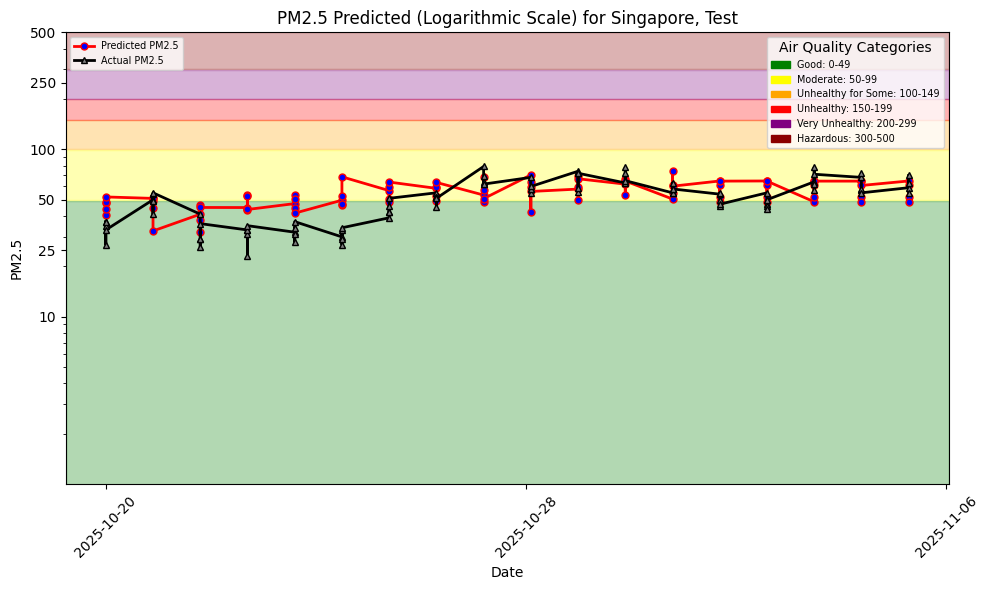

In [394]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['timestamp']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

file_path = images_dir + "/pm25_hindcast.png"
plt = plot_air_quality_forecast('Singapore', 'Test', df, file_path, hindcast=True) 
plt.show()

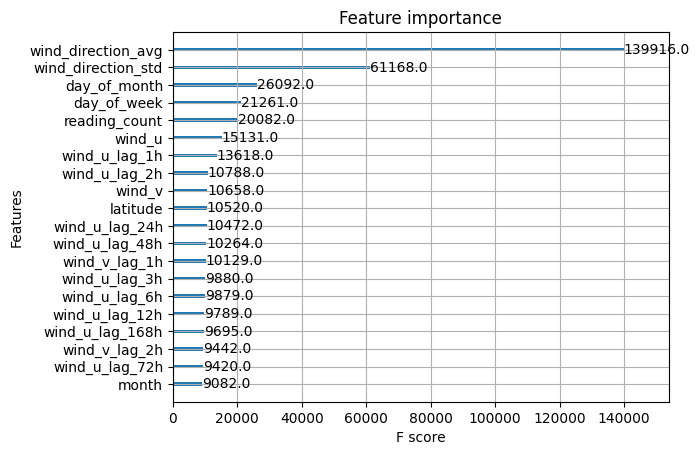

In [400]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=20)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()